<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/EXP/%5BE-05%5D/%5BE_05%5D%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files,drive
drive.mount('/content/drive')

# # 리눅스 이미지 세팅 명령어 저장
# unzip scissor-samples.zip -d /content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor/sam
# unzip scissor_1109.zip -d /content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor/j1109
# unzip scissor-moon.zip -d /content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor/moon
# unzip real_scissor.zip -d /content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor/real
# unzip scissor.zip -d /content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor
# rename 's/.jpg/a_*.jpg/' *.jpg
# rename 's/.jpg/sam_*.jpg/' *.jpg
# rename 's/.jpg/m_*.jpg/' *.jpg
# rename 's/.jpg/r_*.jpg/' *.jpg
# cp * /content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf
from tensorflow import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [3]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 128x128 사이즈로 바꾸어 저장합니다.
	target_size=(128,128)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
paper_image_dir_path = '/content/drive/MyDrive/Aiffel/data/rock_scissor_paper/paper'
resize_images(paper_image_dir_path)

print("보 이미지 resize 완료!")

1316  images to be resized.
1316  images resized.
보 이미지 resize 완료!


In [4]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
rock_image_dir_path = '/content/drive/MyDrive/Aiffel/data/rock_scissor_paper/rock'
resize_images(rock_image_dir_path)

print("바위 이미지 resize 완료!")

1371  images to be resized.
1371  images resized.
바위 이미지 resize 완료!


In [5]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_image_dir_path = '/content/drive/MyDrive/Aiffel/data/rock_scissor_paper/scissor'
resize_images(scissor_image_dir_path)

print("가위 이미지 resize 완료!")

1346  images to be resized.
1346  images resized.
가위 이미지 resize 완료!


In [6]:
def load_data(img_path, number_of_data=4033):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=128
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.
                    int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = '/content/drive/MyDrive/Aiffel/data/rock_scissor_paper'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 4033 입니다.
x_train shape: (4033, 128, 128, 3)
y_train shape: (4033,)


라벨:  0


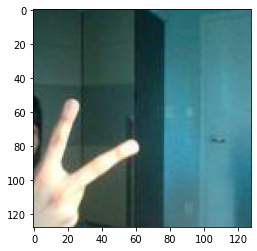

In [7]:
plt.imshow(x_train[250])
print('라벨: ', y_train[250])

In [8]:
x_train.shape

(4033, 128, 128, 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train_norm, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [10]:
x_train = tf.image.central_crop(x_train,central_fraction=0.7)
x_val = tf.image.central_crop(x_val,central_fraction=0.7)

라벨:  1


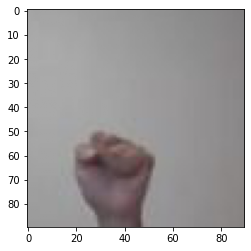

In [11]:
x_train.shape
plt.imshow(x_train[150])
print('라벨: ', y_train[150])

In [12]:
activate = 'relu'
conv1 = 8
conv2 = 16
conv3 = 64
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(conv1,(3,3),padding='same',activation=activate,input_shape=(90,90,3)))
model.add(keras.layers.Conv2D(conv1,(3,3),activation=activate))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(conv2,(3,3),activation=activate))
model.add(keras.layers.Conv2D(conv2,(3,3),activation=activate))
model.add(keras.layers.MaxPooling2D(2,2))

model.add(keras.layers.Conv2D(conv3,(3,3),activation=activate))
model.add(keras.layers.Conv2D(conv3,(3,3),activation=activate))
model.add(keras.layers.MaxPooling2D(2,2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32,activation=activate))
tf.keras.layers.Dropout(.3) 
model.add(keras.layers.Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 90, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 16)       0         
 2D)                                                    

In [13]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best-model.h5',save_best_only=True)
early_stopping = EarlyStopping(patience=9)
train_model = model.fit(x_train, y_train, epochs=50,callbacks = [early_stopping,checkpoint],validation_data=(x_val,y_val))

Epoch 1/50
89/89 [==============================] - 5s 20ms/step - loss: 1.0095 - accuracy: 0.4488 - val_loss: 0.9225 - val_accuracy: 0.5413
Epoch 2/50
89/89 [==============================] - 1s 14ms/step - loss: 0.8304 - accuracy: 0.5873 - val_loss: 0.8565 - val_accuracy: 0.6182
Epoch 3/50
89/89 [==============================] - 1s 15ms/step - loss: 0.6791 - accuracy: 0.6978 - val_loss: 0.6221 - val_accuracy: 0.7289
Epoch 4/50
89/89 [==============================] - 1s 14ms/step - loss: 0.5138 - accuracy: 0.7896 - val_loss: 0.5730 - val_accuracy: 0.7595
Epoch 5/50
89/89 [==============================] - 1s 14ms/step - loss: 0.3509 - accuracy: 0.8512 - val_loss: 0.3605 - val_accuracy: 0.8562
Epoch 6/50
89/89 [==============================] - 1s 14ms/step - loss: 0.2370 - accuracy: 0.9029 - val_loss: 0.2757 - val_accuracy: 0.8884
Epoch 7/50
89/89 [==============================] - 1s 14ms/step - loss: 0.1901 - accuracy: 0.9253 - val_loss: 0.2318 - val_accuracy: 0.9083
Epoch 8/50
89

In [14]:
model = keras.models.load_model('best-model.h5')
val_loss, val_accuracy = model.evaluate(x_val,y_val, verbose=2)
print("val_loss: {} ".format(val_loss))
print("val_accuracy: {}".format(val_accuracy))

38/38 - 0s - loss: 0.1294 - accuracy: 0.9678 - 328ms/epoch - 9ms/step
val_loss: 0.1294126659631729 
val_accuracy: 0.9677686095237732


In [15]:
# def render_training_history(training_history):
#     loss = training_history.history['loss']
#     val_loss = training_history.history['val_loss']

#     accuracy = training_history.history['accuracy']
#     val_accuracy = training_history.history['val_accuracy']

#     plt.figure(figsize=(14, 4))

#     plt.subplot(1, 2, 1)
#     plt.title('Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.plot(loss, label='Training set')
#     plt.plot(val_loss, label='Test set', linestyle='--')
#     plt.legend()
#     plt.grid(linestyle='--', linewidth=1, alpha=0.5)

#     plt.subplot(1, 2, 2)
#     plt.title('Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.plot(accuracy, label='Training set')
#     plt.plot(val_accuracy, label='Test set', linestyle='--')
#     plt.legend()
#     plt.grid(linestyle='--', linewidth=1, alpha=0.5)

#     plt.show()
# render_training_history(model)

TEST SET 구성

In [16]:
paper_testimage_dir_path = '/content/drive/MyDrive/Aiffel/data/test/paper'
resize_images(paper_testimage_dir_path)
rock_testimage_dir_path = '/content/drive/MyDrive/Aiffel/data/test/rock'
resize_images(rock_testimage_dir_path)
scissor_testimage_dir_path = '/content/drive/MyDrive/Aiffel/data/test/scissor'
resize_images(scissor_testimage_dir_path)

print("test 이미지 resize 완료!")

200  images to be resized.
200  images resized.
200  images to be resized.
200  images resized.
200  images to be resized.
200  images resized.
test 이미지 resize 완료!


In [17]:
def test_load_data(img_path, number_of_data=600):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=128
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.
                    int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

test_image_dir_path = '/content/drive/MyDrive/Aiffel/data/test'
(x_test, y_test)=test_load_data(test_image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 600 입니다.
x_test shape: (600, 128, 128, 3)
y_test shape: (600,)


In [18]:
x_test_norm = tf.image.central_crop(x_test_norm,central_fraction=0.7)
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


19/19 - 0s - loss: 1.6842 - accuracy: 0.5100 - 266ms/epoch - 14ms/step
test_loss: 1.6841739416122437 
test_accuracy: 0.5099999904632568
